# Построение моделей для решения задачи классификации (бинарная)

Импорт необходимых библиотек

In [102]:
import numpy as np
import pandas as pd
import matplotlib as plt
from imblearn.over_sampling import SMOTE

Загрузка датасета

Целевой признак - bomb_planted

In [103]:
data = pd.read_csv('csgo_filtred.csv')

y = data['bomb_planted']
X = data.drop(columns=['bomb_planted'], axis=1)

# Проверка баланса классов

In [104]:
X.head()

,time_left,ct_score,t_score,map,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,health_lead,armor_lead,money_lead,helmets_lead,players_alive_lead
0,175.00,0,0,de_dust2,500,500,0,0,4000,4000,0,0,0,5,5,2,2,2,2,2
1,156.03,0,0,de_dust2,500,500,400,300,600,650,0,0,1,5,5,2,0,1,2,2
2,96.03,0,0,de_dust2,391,400,294,200,750,500,0,0,1,4,4,1,0,0,2,2
3,76.03,0,0,de_dust2,391,400,294,200,750,500,0,0,1,4,4,1,0,0,2,2
4,174.97,1,0,de_dust2,500,500,192,0,18350,10750,0,0,1,5,5,2,0,0,2,2


<Axes: ylabel='bomb_planted'>

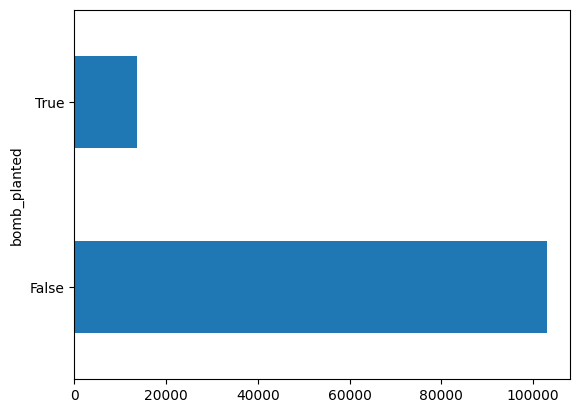

In [105]:
y.value_counts().plot.barh()

In [106]:
y.value_counts()

bomb_planted
False    102945
True      13684
Name: count, dtype: int64

Видно, что классы максимально несбалансированы, количество класса false превосходит класс true более чем в 5 раз.

Для балансировки буду использовать метод SMOTE, он создаёт дополнительные точки для минаритарного класса, основываясь на уже существующих точках.

Но для начала преобразую переменные признака map в числовые.

In [107]:
X['map'].value_counts()

map
de_inferno     22806
de_dust2       21040
de_nuke        17879
de_mirage      17641
de_overpass    13375
de_train       12800
de_vertigo     10733
unknown          211
de_cache         144
Name: count, dtype: int64

In [108]:
X['map'] = X['map'].str.strip().str.lower()

In [109]:
mapping = {
    'de_inferno': 1,
    'de_dust2': 2,
    'de_nuke': 3,
    'de_mirage': 4,
    'de_overpass': 5,
    'de_train': 6,
    'de_vertigo': 7,
    'unknown': 8,
    'de_cache': 9
}

X['map'] = X['map'].map(mapping)
X['map'].value_counts()

map
1    22806
2    21040
3    17879
4    17641
5    13375
6    12800
7    10733
8      211
9      144
Name: count, dtype: int64

In [110]:
oversample = SMOTE()
transformed_X, tranformed_y = oversample.fit_resample(X, y)

In [111]:
print(f'old: {y.value_counts()}')
print(f'new: {tranformed_y.value_counts()}')

old: bomb_planted
False    102945
True      13684
Name: count, dtype: int64
new: bomb_planted
False    102945
True     102945
Name: count, dtype: int64


In [112]:
X, y = transformed_X, tranformed_y

Как можно увидеть балансировка по классам получилась успешной, теперь мы имеем два класса с одинаковым количеством точек.